LR Pipeline → RMSE: 0.07
RF Pipeline → RMSE: 0.40
Linear Regression → RMSE: 0.07, R²: 1.000
Random Forest      → RMSE: 0.39, R²: 0.996


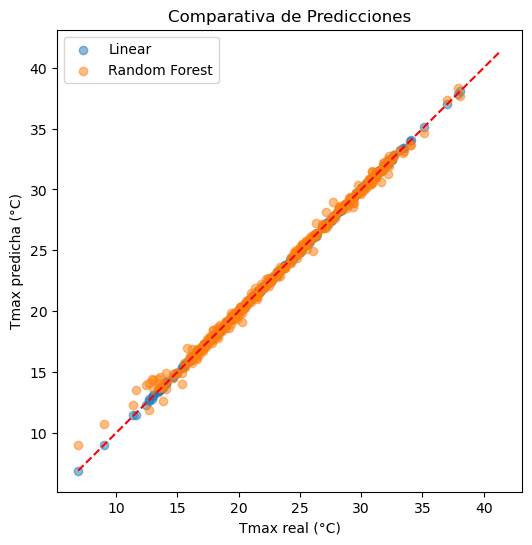

🔍 Validación cruzada (5‐fold):
RMSE medio: 0.07  ±  0.00


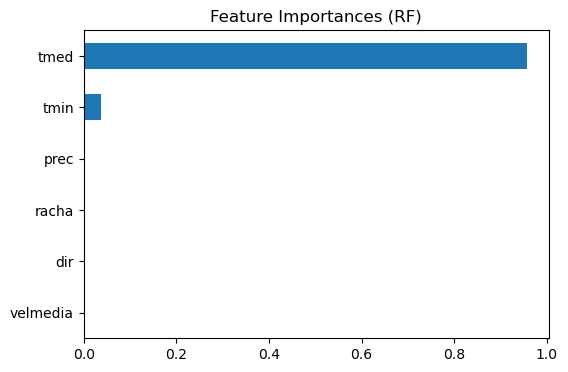

✅ Pipelines guardados: pipeline_tmax_lr.pkl y pipeline_tmax_rf.pkl
✅ Dataset exportado: C:\Users\lumin\Desktop\2 Cuatri\Evaluación, Despliegue y Monitorización de Modelos\urbanheat_valencia\data\processed\datos_modelo.csv


In [9]:
# 📦 Librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection   import train_test_split
from sklearn.linear_model      import LinearRegression
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, r2_score

import joblib

# 📁 Cargar datos limpios
ruta = r"C:\Users\lumin\Desktop\2 Cuatri\Evaluación, Despliegue y Monitorización de Modelos\urbanheat_valencia\data\processed\temperatura_valencia_limpia.csv"
df = pd.read_csv(ruta, parse_dates=["fecha"])

# 🔍 Selección de variables
variables = ["tmed", "tmin", "prec", "velmedia", "racha", "dir"]
objetivo  = "tmax"
df_modelo = df[variables + [objetivo]].dropna()

X = df_modelo[variables]
y = df_modelo[objetivo]

from sklearn.pipeline import Pipeline
from sklearn.impute    import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ── Creamos un pipeline base para preprocesar + estimador ────────────────
preproc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # reemplaza NaN por mediana
    ("scaler",  StandardScaler()),                  # centra y escala
])

# ── Pipeline con LinearRegression ─────────────────────────────────────────
pipe_lr = Pipeline([
    ("preproc", preproc),
    ("model",   LinearRegression()),
])

# ── Pipeline con RandomForest ─────────────────────────────────────────────
pipe_rf = Pipeline([
    ("preproc", preproc),
    ("model",   RandomForestRegressor(n_estimators=100, random_state=42)),
])

# Ahora dividimos y entrenamos directamente el pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predecimos y evaluamos igual que antes
y_pred_lr = pipe_lr.predict(X_test)
y_pred_rf = pipe_rf.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"LR Pipeline → RMSE: {rmse_lr:.2f}")
print(f"RF Pipeline → RMSE: {rmse_rf:.2f}")


# ✂️ División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 📈 1) Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr   = r2_score(y_test, y_pred_lr)
print(f"Linear Regression → RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}")

# 📈 2) Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)
print(f"Random Forest      → RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

# 📊 Scatter plot LR vs real
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr,    alpha=0.5, label="Linear")
plt.scatter(y_test, y_pred_rf,    alpha=0.5, label="Random Forest")
xmin, xmax = y.min(), y.max()
plt.plot([xmin,xmax],[xmin,xmax],"r--")
plt.xlabel("Tmax real (°C)")
plt.ylabel("Tmax predicha (°C)")
plt.title("Comparativa de Predicciones")
plt.legend()
plt.show()

# ——— VALIDACIÓN CRUZADA —————————————————————————————————————————
from sklearn.model_selection import cross_val_score
import numpy as np

# Usamos MSE negativo y luego sqrt para obtener RMSE
scores = cross_val_score(
    modelo,
    X, y,
    cv=5,
    scoring="neg_mean_squared_error",  # devuelve -MSE
)
rmse_scores = np.sqrt(-scores)

print("🔍 Validación cruzada (5‐fold):")
print(f"RMSE medio: {rmse_scores.mean():.2f}  ±  {rmse_scores.std():.2f}")


# 📊 Importancias de RF
importances = pd.Series(
    rf.feature_importances_,
    index=variables
).sort_values()
importances.plot.barh(
    figsize=(6,4),
    title="Feature Importances (RF)"
)
plt.show()

# 💾 Serializar pipelines completos
output_dir = r"C:\Users\lumin\Desktop\2 Cuatri\Evaluación, Despliegue y Monitorización de Modelos\urbanheat_valencia\models"

joblib.dump(pipe_lr, f"{output_dir}/pipeline_tmax_lr.pkl")
joblib.dump(pipe_rf, f"{output_dir}/pipeline_tmax_rf.pkl")
print("✅ Pipelines guardados: pipeline_tmax_lr.pkl y pipeline_tmax_rf.pkl")

# 📝 Exportar datos usados
dataset_modelo_path = r"C:\Users\lumin\Desktop\2 Cuatri\Evaluación, Despliegue y Monitorización de Modelos\urbanheat_valencia\data\processed\datos_modelo.csv"
df_modelo.to_csv(dataset_modelo_path, index=False)
print(f"✅ Dataset exportado: {dataset_modelo_path}")

